In [441]:
import pandas as pd 
import torch 
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [442]:
import sys 
sys.path.append("../")
from bridge.trainer_dsb import IPF_DSB

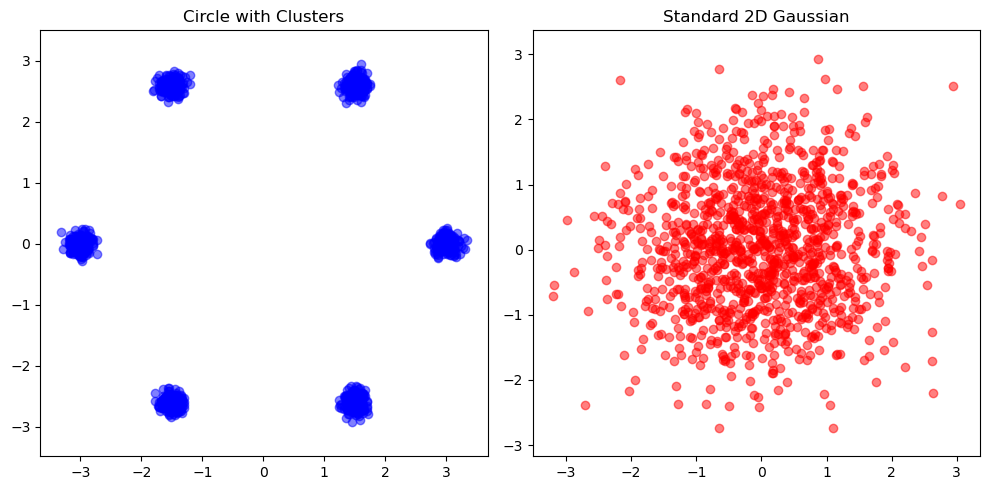

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class DistributionBridge:
    def __init__(self, n_clusters=6, cluster_std=0.1, radius=3, n_samples_per_cluster=200):
        self.n_clusters = n_clusters
        self.cluster_std = cluster_std
        self.radius = radius
        self.n_samples_per_cluster = n_samples_per_cluster
        self.total_samples = n_clusters * n_samples_per_cluster
        self.circle_distribution = None
        self.gaussian_distribution = None

    def generate_circle_distribution(self):
        # Angles for each cluster, equally spaced around the circle
        angles = np.linspace(0, 2 * np.pi, self.n_clusters, endpoint=False)
        cluster_centers = np.array([(self.radius * np.cos(angle), self.radius * np.sin(angle)) for angle in angles])

        # Generate Gaussian clusters around each center
        points = []
        for center in cluster_centers:
            x, y = np.random.normal(center[0], self.cluster_std, self.n_samples_per_cluster), \
                   np.random.normal(center[1], self.cluster_std, self.n_samples_per_cluster)
            points.append(np.vstack((x, y)).T)

        self.circle_distribution = np.vstack(points)
        return self.circle_distribution
    def generate_gaussian_distribution(self):
        # Generate standard 2D Gaussian samples
        self.gaussian_distribution = np.random.normal(0, 1, (self.total_samples, 2))
        return self.gaussian_distribution
    def plot_distributions(self):
        # Plot the circle distribution with clusters
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.scatter(self.circle_distribution[:, 0], self.circle_distribution[:, 1], color='blue', alpha=0.5)
        plt.title('Circle with Clusters')
        plt.axis('equal')

        # Plot the standard 2D Gaussian distribution
        plt.subplot(1, 2, 2)
        plt.scatter(self.gaussian_distribution[:, 0], self.gaussian_distribution[:, 1], color='red', alpha=0.5)
        plt.title('Standard 2D Gaussian')
        plt.axis('equal')

        plt.tight_layout()
        plt.show()

# Example usage:
distribution_bridge = DistributionBridge(n_clusters=6, cluster_std=0.1, radius=3, n_samples_per_cluster=200)
distribution_bridge.generate_circle_distribution()
distribution_bridge.generate_gaussian_distribution()
distribution_bridge.plot_distributions()

In [7]:
IPF_DSB(init_ds, final_ds, 0, 1)

TypeError: __init__() missing 1 required positional argument: 'args'

In [ ]:
def train_dsbm(dsbm_ipf, x_pairs, batch_size, inner_iters, prev_model=None, fb='', first_it=False):
  assert fb in ['f', 'b']
  dsbm_ipf.fb = fb
  optimizer = torch.optim.Adam(dsbm_ipf.net_dict[fb].parameters(), lr=lr)
  # optimizer = dsbm_ipf.optimizer_dict[fb]
  loss_curve = []
  
  dl = iter(DataLoader(TensorDataset(*dsbm_ipf.generate_new_dataset(x_pairs, prev_model=prev_model, fb=fb, first_it=first_it)), 
                       batch_size=batch_size, shuffle=True, pin_memory=False, drop_last=True))

  for i in tqdm(range(inner_iters)):
    try:
      z0, z1 = next(dl)
    except StopIteration:
      dl = iter(DataLoader(TensorDataset(*dsbm_ipf.generate_new_dataset(x_pairs, prev_model=prev_model, fb=fb, first_it=first_it)), 
                           batch_size=batch_size, shuffle=True, pin_memory=False, drop_last=True))
      z0, z1 = next(dl)
    
    z_pairs = torch.stack([z0, z1], dim=1)
    z_t, t, target = dsbm_ipf.get_train_tuple(z_pairs, fb=fb, first_it=first_it)
    optimizer.zero_grad()
    pred = dsbm_ipf.net_dict[fb](z_t, t)
    loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
    loss = loss.mean()
    loss.backward()
    
    if torch.isnan(loss).any():
      raise ValueError("Loss is nan")
      break
    
    optimizer.step()
    loss_curve.append(np.log(loss.item())) ## to store the loss curve

  return dsbm_ipf, loss_curve

In [360]:
class DSBM(nn.Module):
  def __init__(self, net_fwd=None, net_bwd=None, num_steps=1000, sig=0, eps=1e-3, first_coupling="ref", device = "cuda:0"):
    super().__init__()
    self.net_fwd = net_fwd
    self.net_bwd = net_bwd
    self.net_dict = {"f": self.net_fwd, "b": self.net_bwd}
    # self.optimizer_dict = {"f": torch.optim.Adam(self.net_fwd.parameters(), lr=lr), "b": torch.optim.Adam(self.net_bwd.parameters(), lr=lr)}
    self.N = num_steps
    self.sig = sig
    self.eps = eps
    self.first_coupling = first_coupling
    self.device = device
  
  @torch.no_grad()
  def get_train_tuple(self, x_pairs=None, fb='', **kwargs):
    z0, z1 = x_pairs[:, 0], x_pairs[:, 1]
    t = torch.rand((z1.shape[0], 1), device=self.device) * (1-2*self.eps) + self.eps
    z_t = t * z1 + (1.-t) * z0
    # print(x_pairs.shape, z_t.shape, t.shape, z0.shape)
    
    z = torch.randn_like(z_t)
    z_t = z_t + self.sig * torch.sqrt(t*(1.-t)) * z
    # print(x_pairs.shape, z_t.shape, t.shape)
    if fb == 'f':
      # z1 - z_t / (1-t)
      target = z1 - z0 
      target = target - self.sig * torch.sqrt(t/(1.-t)) * z
    else:
      # z0 - z_t / t
      target = - (z1 - z0)
      target = target - self.sig * torch.sqrt((1.-t)/t) * z
      z_t, t, target = z_t.to(torch.float32), t.to(torch.float32), target.to(torch.float32)
    return z_t, t, target

  @torch.no_grad()
  def generate_new_dataset(self, x_pairs, prev_model=None, fb='', first_it=False):
    assert fb in ['f', 'b']

    if prev_model is None:
      assert first_it
      assert fb == 'b'
      # print(x_pairs)
      x_pairs = torch.cat(x_pairs, dim = 1)
      zstart = x_pairs[:, 0]
      if self.first_coupling == "ref":
        # First coupling is x_0, x_0 perturbed
        zend = zstart + torch.randn_like(zstart) * self.sig
      elif self.first_coupling == "ind":
        zend = x_pairs[:, 1].clone()
        zend = zend[torch.randperm(len(zend))]
      else:
        raise NotImplementedError
      z0, z1 = zstart, zend
    else:
      assert not first_it
      if prev_model.fb == 'f':
        zstart = x_pairs[:, 0]
      else:
        zstart = x_pairs[:, 1]
      zend = prev_model.sample_sde(zstart=zstart, fb=prev_model.fb)[-1]
      if prev_model.fb == 'f':
        z0, z1 = zstart, zend
      else:
        z0, z1 = zend, zstart
    return z0, z1

  @torch.no_grad()
  def sample_sde(self, zstart=None, N=None, fb='', first_it=False):
    assert fb in ['f', 'b']
    ### NOTE: Use Euler method to sample from the learned flow
    if N is None:
      N = self.N   
    dt = 1./N
    traj = [] # to store the trajectory
    z = zstart.detach().clone()
    batchsize = z.shape[0]
    
    traj.append(z.detach().clone())
    ts = np.arange(N) / N
    if fb == 'b':
      ts = 1 - ts
    for i in range(N):
      t = torch.ones((batchsize,1), device=self.device) * ts[i]
      pred = self.net_dict[fb](z.to(torch.float32), t.to(torch.float32))
      z = z.detach().clone() + pred * dt
      z = z + self.sig * torch.randn_like(z) * np.sqrt(dt)
      traj.append(z.detach().clone())

    return traj



In [361]:
class F_model(nn.Module):
    def __init__(self, input_dim, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
        )
        self.output_net = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )
        self.time_emb = nn.Linear(1, 64)
    def forward(self, x, t):
        x = self.net(x)
        t_emb = self.time_emb(t)
        output = self.output_net(torch.cat([x, t_emb], dim = -1))
        return output
    


In [362]:
F_net = F_model(2)
B_net = F_model(2)

In [363]:
dsbm = DSBM(net_fwd = F_net, net_bwd = B_net)

In [364]:
num_sample = 10000

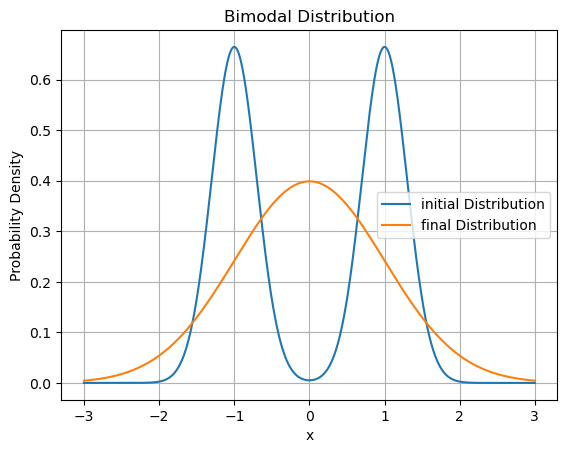

In [366]:
total_ds = torch.from_numpy(np.concatenate([initial_ds, final_ds], axis = 1))

In [367]:
dsbm = DSBM(F_model(1), F_model(1), 10, 1, device="cpu")
# print()
z_t, t, target = dsbm.get_train_tuple(torch.from_numpy(np.concatenate([initial_ds, final_ds], axis = 1)), fb = "f")

In [368]:
print(target)

tensor([[ 2.7502, -1.1121, -1.8970,  ..., -1.5693, -5.0591,  2.4912],
        [ 0.2098,  0.0118, -0.1642,  ...,  1.5882,  0.6096,  0.5143],
        [-0.5813, -0.5732,  0.4158,  ...,  0.7469, -0.4213, -0.4922],
        ...,
        [ 0.6234, -0.0360, -2.2824,  ...,  1.0945,  0.6012,  0.1092],
        [ 1.8638, -1.1112,  2.8078,  ..., -0.0518, -0.7410,  0.7406],
        [-0.5554,  1.0011,  0.5993,  ...,  0.3140, -0.9969,  0.0202]],
       dtype=torch.float64)


In [369]:
# print(z_t.shape)
# plt.hist(z_t.numpy())
# plt.hist(t*999, bins = 100)

In [370]:
x_pairs = dsbm.generate_new_dataset((torch.from_numpy(initial_ds), torch.from_numpy(final_ds)), None, "b", first_it=True)

In [371]:
print(x_pairs)

(tensor([1.4852e-10, 1.5051e-10, 1.5253e-10,  ..., 1.5253e-10, 1.5051e-10,
        1.4852e-10], dtype=torch.float64), tensor([ 0.9129, -2.2078,  0.6032,  ...,  1.0314, -0.3807, -1.8348],
       dtype=torch.float64))


In [372]:
# train_elem = dsbm.get_train_tuple(x_pairs=torch.cat(x_pairs, dim = -1), fb = 'f')

In [373]:
# traj = dsbm.sample_sde(x_pairs[1], N = 1000, fb = "b",first_it=True)

In [374]:
# # print(len(traj))
# traj = torch.cat(traj, axis = -1)
# traj = traj.numpy()

In [375]:
# print(traj)

In [376]:
# plt.figure(figsize = (8,8))
# for i in range(0, 737):
#     plt.plot(np.arange(0, 1001), traj[i, : ], color = "#046261", alpha = 0.1)

In [391]:
# print(x_pairs[0].shape)
x_pairs = (torch.from_numpy(initial_ds).unsqueeze(-1), torch.from_numpy(final_ds).unsqueeze(-1))

In [386]:
final_dspm, loss_curve = train_dsbm(dsbm_ipf=dsbm, x_pairs= x_pairs, batch_size = 1000, inner_iters=1, fb = "b", first_it= True)

100%|██████████| 1/1 [00:00<00:00, 55.48it/s]


In [392]:
final_dspm, loss_curve = train_dsbm(dsbm_ipf=final_dspm, prev_model=final_dspm, x_pairs= x_pairs, batch_size = 1000, inner_iters=1, fb = "f", first_it= False)


TypeError: tuple indices must be integers or slices, not tuple

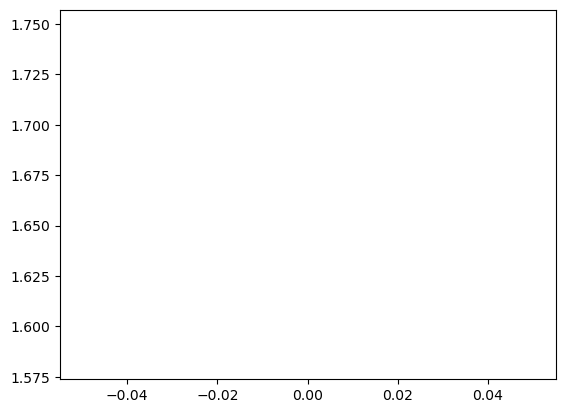

In [387]:
plt.plot(loss_curve)

In [394]:
print(initial_ds)

[[1.48515003e-10]
 [1.50508363e-10]
 [1.52527867e-10]
 ...
 [1.52527867e-10]
 [1.50508363e-10]
 [1.48515003e-10]]


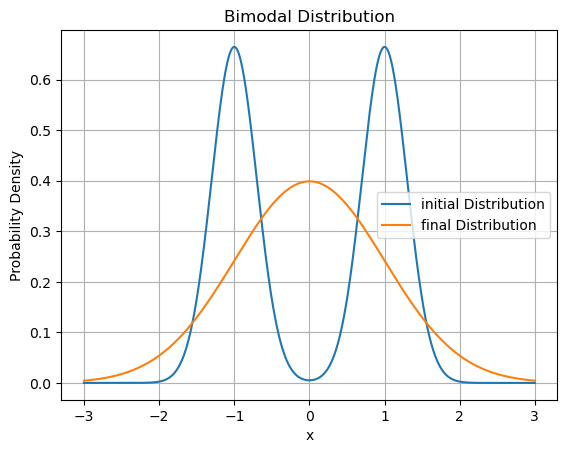

In [462]:
def normal_distribution(x, mean, std):
    return (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean)/std) ** 2)

x = np.linspace(-3, 3, num_sample)
mean1, std1, weight1 = -1, 0.3, 0.5
mean2, std2, weight2 = 1, 0.3, 0.5

initial_ds = weight1 * normal_distribution(x, mean1, std1) + weight2 * normal_distribution(x, mean2, std2)
final_ds = normal_distribution(x, 0, 1)
initial_ds = initial_ds[:, np.newaxis]
final_ds = final_ds[:, np.newaxis]

plt.plot(x, initial_ds, label="initial Distribution")
plt.plot(x, final_ds, label="final Distribution")
plt.title("Bimodal Distribution")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()

In [463]:
class X_ds(Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data).to(torch.float32)
    def __getitem__(self, index):
        return self.data[index, ...]
    def __len__(self):
        return len(self.data)

In [464]:
class Xpair(Dataset):
    def __init__(self, init_ds, final_ds):
        self.init_ds = init_ds
        self.final_ds = final_ds
        assert len(self.init_ds) == len(self.final_ds)
    def __getitem__(self, index):
        return {"x0": self.init_ds[index], "xT":self.final_ds[index]}
    def __len__(self):
        return len(self.init_ds)

In [473]:


def get_xt(x0, xT, t, sigma):
    assert (x0.shape[0] == xT.shape[0]) & (xT.shape[0] == t.shape[0])
    xt = (1-t)*x0 + (t)*xT + sigma*(t*(1-t)).sqrt()*torch.rand_like(x0)
    return xt

def loss_fn(x0, xT, t, sigma, v_t):
    # return (x0 - xT - sigma*torch.sqrt((1-t)/t)*torch.randn_like(x0) - v_t).abs().pow(2)/(1 + sigma**2*(t/(1-t)))
    return (x0 - xT - sigma*torch.sqrt((1-t)*t)*torch.randn_like(x0) - v_t).abs().pow(2)/(1 + sigma**2*(t/(1-t)))
    

def lagvein(x0, model, time_step, reverse = False,  sigma = 1, device = "cpu"):
    model.eval()
    ts = np.arange(0, time_step)/time_step
    ts = ts[::-1] if reverse else ts
    dt = 1./time_step
    x = x0
    for ti in ts:
        t = torch.ones((x.shape[0],1), device=device) * ti
        pred = model(x, t)
        x = x.detach().clone() + pred * dt
        x = x + sigma * torch.randn_like(x) * np.sqrt(dt)
    return x
def lagvein_ds(x_ds, batch_size, model, time_step, reverse, sigma, device):
    x_new = []
    for data in DataLoader(x_ds, batch_size = batch_size):
        x_new.append(lagvein(data, model, time_step, reverse = reverse,  sigma = sigma, device = device))
    return torch.cat(x_new, dim = 0)

100%|██████████| 10/10 [00:39<00:00,  3.99s/it]


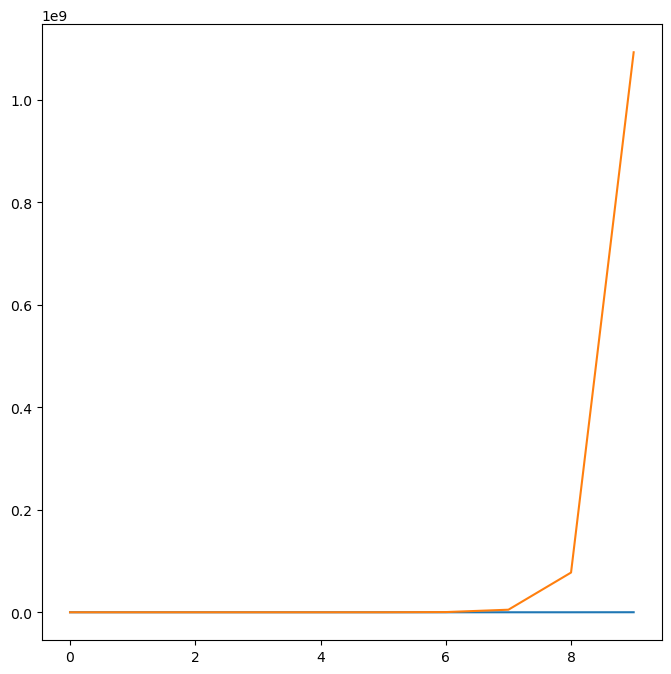

(F_model(
   (net): Sequential(
     (0): Linear(in_features=1, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
   )
   (output_net): Sequential(
     (0): Linear(in_features=128, out_features=32, bias=True)
     (1): ReLU()
     (2): Linear(in_features=32, out_features=1, bias=True)
   )
   (time_emb): Linear(in_features=1, out_features=64, bias=True)
 ),
 F_model(
   (net): Sequential(
     (0): Linear(in_features=1, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
   )
   (output_net): Sequential(
     (0): Linear(in_features=128, out_features=32, bias=True)
     (1): ReLU()
     (2): Linear(in_features=32, out_features=1, bias=True)
   )
   (time_emb): Linear(in_features=1, out_features=64, bias=True)
 ))

In [478]:
def train_dsbm(initial_dist:Dataset, final_dist:Dataset, f_model:nn.Module, b_model:nn.Module, optimizer_f:torch.optim, optimizer_b: torch.optim, time_step:int, epochs = 10, batch_size = 100, sigma = 1, device = "cpu"):
    t = torch.randint(0, time_step, (batch_size,))/time_step
    loss_f = []
    loss_b = []
    # print(t)
    initial_ds = initial_dist
    final_ds = final_dist
    x_pair_dl = DataLoader(Xpair(initial_ds, final_ds), batch_size=batch_size)
    eps = 1e-5
    for epoch in tqdm(range(0, epochs)):
        total_loss_f = 0
        total_loss_b = 0
        # train backward process:
        f_model.train()
        for data in x_pair_dl:
            t = torch.rand((data['x0'].shape[0], 1)).to(torch.float32)
            x_t= get_xt(data['x0'], data['xT'],t, sigma = sigma)
            optimizer_f.zero_grad()
            pred = f_model(x_t.to(torch.float32), t)
            
            loss = loss_fn(data['x0'], data['xT'],t, sigma, pred)
            # print(loss)
            loss = loss.mean()
            loss.backward()
            optimizer_f.step()
            total_loss_f += loss.item()
        loss_f.append(total_loss_f/len(x_pair_dl))
            
        # train forward process:
        b_model.train()
        with torch.no_grad():
            initial_ds = lagvein_ds(initial_ds, batch_size, f_model, time_step=time_step, reverse=False, sigma = sigma, device = device)
        x_pair_dl = DataLoader(Xpair(initial_ds, final_ds), batch_size=batch_size)
        for data in x_pair_dl:
            
            t = torch.rand((data['x0'].shape[0], 1)).to(torch.float32)
            optimizer_b.zero_grad()
            pred = b_model(x_t.to(torch.float32), t)
            loss = loss_fn(data['x0'], data['xT'],t, sigma, pred)
            
            # loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
            loss = loss.mean()
            loss.backward()
            optimizer_b.step()
            total_loss_b += loss.item()
        loss_b.append(total_loss_b)
        with torch.no_grad():
            final_ds = lagvein_ds(final_ds, batch_size, b_model, time_step=time_step, reverse=True, sigma = sigma, device = device)
            x_pair_dl = DataLoader(Xpair(initial_ds, final_ds), batch_size=batch_size)
    
    plt.figure(figsize = (8,8))
    plt.plot([i for i in range(epochs)], loss_f, label = "forward loss")
    plt.plot([i for i in range(epochs)], loss_b, label = "backward loss")
    plt.show()
    return f_model, b_model

f_model = F_model(1)
b_model = F_model(1)
f_optimer = torch.optim.Adam(f_model.parameters(), lr = 1e-4)
b_optimer = torch.optim.Adam(b_model.parameters(), lr = 1e-4)
init_ds = X_ds(initial_ds)
fin_ds = X_ds(final_ds)

train_dsbm(initial_dist=fin_ds, final_dist=init_ds, f_model=f_model, b_model=b_model, optimizer_f= f_optimer, optimizer_b=b_optimer, time_step=100, epochs = 10, batch_size=100)